In [3]:
import numpy as np

fname = "/home/Developer/genomics_ood/images_ood/image_data/brain_train.npy"
with open(fname, "rb") as f:
    x = np.load(f)

In [5]:
x.dtype

dtype('float32')

In [7]:
from scipy import ndimage
import matplotlib.pyplot as plt

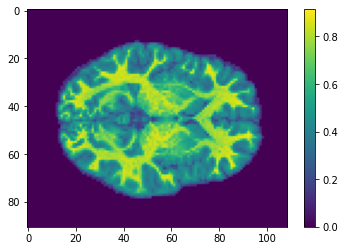

In [17]:
plt.imshow(x[0,...,-1])
plt.colorbar()

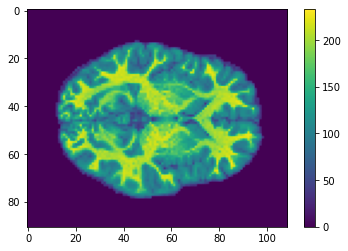

In [16]:
xq = (x[0]*255).astype(np.uint8)
plt.imshow(xq[...,0])
plt.colorbar()

In [18]:
np.min(xq), np.max(xq)

(0, 233)

In [25]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
sys.path.append("/home/Developer/NCSN-TF2.0/")
DATADIR = "/home/Developer/NCSN-TF2.0/data/"

import utils
import pickle
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from ood_detection_helper import *
from datasets.dataset_loader import  *
from tqdm import tqdm

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

tf.__version__

'2.3.1'

In [2]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
model = load_model(inlier_name="cifar10", s_high=1, num_L=20)

(1, 32, 32, 3)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 128)  3584        images[0][0]                     
__________________________________________________________________________________________________
idx_sigmas (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
conditional_full_pre_activation (None, 32, 32, 128)  310528      conv2d[0][0]                     
                                                                 idx_sig

In [4]:
BATCHSIZE = 512

### CIFAR

In [5]:
with tf.device('CPU'):
    data_generators = tfds.load(name="cifar10", batch_size=-1, shuffle_files=False)
    cifar10_test = tf.data.Dataset.from_tensor_slices(data_generators['test']["image"])
    cifar10_test = cifar10_test.map(lambda x: x/255, num_parallel_calls=AUTOTUNE)
    cifar10_test = cifar10_test.batch(BATCHSIZE).cache()
    
    cifar10_train  = tf.data.Dataset.from_tensor_slices(data_generators['train']["image"])
    cifar10_train = cifar10_train.map(lambda x: x/255, num_parallel_calls=AUTOTUNE)
    cifar10_train = cifar10_train.batch(BATCHSIZE).cache()

In [6]:
%%time
cifar10_train_scores = compute_weighted_scores(model, cifar10_train)

Sigma: 0.0100: 100%|██████████| 20/20 [30:27<00:00, 91.36s/it]

CPU times: user 10min 26s, sys: 6min 48s, total: 17min 14s
Wall time: 30min 27s


In [7]:
%%time
cifar10_scores = compute_weighted_scores(model, cifar10_test)

Sigma: 0.0100: 100%|██████████| 20/20 [06:05<00:00, 18.29s/it]

CPU times: user 2min 10s, sys: 1min 23s, total: 3min 33s
Wall time: 6min 6s


### SVHN

In [15]:
with tf.device('CPU'):
    data_generators = tfds.load(name="svhn_cropped", batch_size=-1, shuffle_files=False)
    svhn_test = tf.data.Dataset.from_tensor_slices(data_generators['test']["image"])
#     svhn_test = svhn_test.take(26000)
    svhn_test = svhn_test.map(lambda x: x/255, num_parallel_calls=AUTOTUNE)
    svhn_test = svhn_test.batch(BATCHSIZE).cache()

In [16]:
%%time
svhn_scores = compute_weighted_scores(model, svhn_test)

Sigma: 0.0100: 100%|██████████| 20/20 [15:47<00:00, 47.36s/it]

CPU times: user 5min 41s, sys: 3min 39s, total: 9min 21s
Wall time: 15min 47s


In [17]:
scores = {}
scores["train"] = cifar10_train_scores
scores["cifar"] = cifar10_scores
scores["svhn"] = svhn_scores

In [18]:
scores.keys()

dict_keys(['train', 'cifar', 'svhn'])

In [19]:
[x.shape for x in scores.values()]

[TensorShape([50000, 20]), TensorShape([10000, 20]), TensorShape([26032, 20])]

In [20]:
scores.keys()

dict_keys(['train', 'cifar', 'svhn'])

In [21]:
# with open("ablation/SH1_L20.p", "wb") as f:
#     pickle.dump(scores, f)

In [26]:
datasets = ["LSUN", "LSUN_resize", "Imagenet", "Imagenet_resize", "iSUN"] 
img_height, img_width = 32, 32

@tf.function
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

@tf.function
def process_path(file_path):
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    img /= 255 
    return img

In [27]:
test_ds = []
BATCHSIZE = 512
for ds_name in datasets:
    data_dir = DATADIR + ds_name
    list_ds = tf.data.Dataset.list_files(str(data_dir+'/*/*'))
    ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCHSIZE)
#     ds = ds.take(1)
    ds = ds.prefetch(buffer_size=AUTOTUNE).cache()
    test_ds.append(ds)

In [28]:
for imgs in test_ds[-1].take(1):
    print(np.histogram(imgs[0]))

(array([548, 381, 292, 340, 316, 193, 181, 178, 254, 389]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32))


LSUN


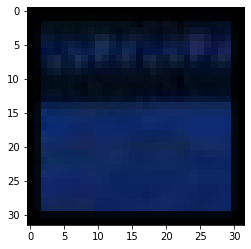

LSUN_resize


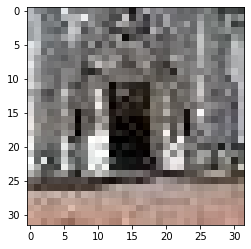

Imagenet


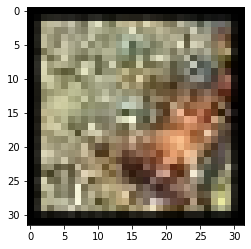

Imagenet_resize


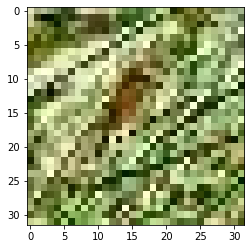

iSUN


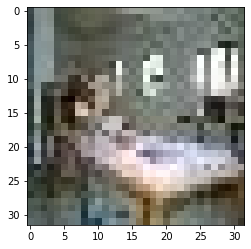

In [29]:
for name, ds in zip(datasets, test_ds):
    image = next(iter(ds.take(1)))
    print(name)
    plt.imshow(image[0].numpy())
    plt.show()

In [30]:
%%time
progress_bar = zip(datasets, test_ds)

for name, outlier in progress_bar:
    print(name)
    scores[name] = compute_weighted_scores(model, outlier)

Sigma: 1.0000:   0%|          | 0/20 [00:00<?, ?it/s]

LSUN


Sigma: 0.0100: 100%|██████████| 20/20 [06:04<00:00, 18.24s/it]


LSUN_resize


Sigma: 0.0100: 100%|██████████| 20/20 [06:04<00:00, 18.22s/it]


Imagenet


Sigma: 0.0100: 100%|██████████| 20/20 [06:05<00:00, 18.27s/it]


Imagenet_resize


Sigma: 0.0336:  70%|███████   | 14/20 [04:31<01:56, 19.39s/it]


KeyboardInterrupt: 

### Artificial Datasets

In [31]:
N_BATCHES = 20

x = tf.random.normal(shape=(BATCHSIZE*N_BATCHES, 32,32,3) , mean=0.5, stddev=1.0)
x = tf.clip_by_value(x, 0.0, 1.0)
gaussian_test_batches = tf.split(x, N_BATCHES)

x = tf.random.uniform(shape=(BATCHSIZE*N_BATCHES, 32,32,3), minval=0.0, maxval=1.0)
uniform_test_batches = tf.split(x, N_BATCHES)

In [32]:
artificial_ood = (gaussian_test_batches, uniform_test_batches)

In [ ]:
%%time
for name, outlier in zip(["gaussian", "uniform"], artificial_ood):
    scores[name] = compute_weighted_scores(model,outlier)

Sigma: 1.0000:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
scores.keys()

In [22]:
# with open("ablation/SH1_L20.p", "wb") as f:
#     pickle.dump(scores, f)

> ### 5% Held out Train

In [ ]:
with tf.device('CPU'):
    data_generators = tfds.load(name="svhn_cropped", batch_size=-1, data_dir="data", shuffle_files=True)
    svhn_test = tf.data.Dataset.from_tensor_slices(data_generators['train[-5%:]']["image"])
    svhn_test = svhn_test.map(lambda x: x/255, num_parallel_calls=AUTOTUNE)
    svhn_test = svhn_test.batch(260)

### CIFAR 10.1

In [23]:
with tf.device('CPU'):
    data_generators = tfds.load(name="cifar10", batch_size=-1, data_dir="data", shuffle_files=True)
    cifar101_test = tf.data.Dataset.from_tensor_slices(data_generators['test']["image"])
    cifar101_test = cifar101_test.map(lambda x: x/255, num_parallel_calls=AUTOTUNE)
    cifar101_test = cifar101_test.batch(512)

(array([415, 783, 297, 227, 194, 150,  95, 354, 389, 168]), array([0.        , 0.08627451, 0.17254902, 0.25882354, 0.34509805,
       0.43137255, 0.5176471 , 0.6039216 , 0.6901961 , 0.7764706 ,
       0.8627451 ], dtype=float32))


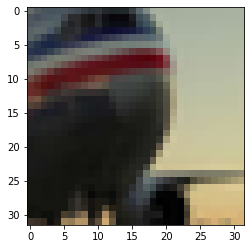

In [24]:
for imgs in cifar101_test.take(1):
    print(np.histogram(imgs[0]))
    plt.imshow(imgs[0].numpy())
    plt.show()

In [25]:
%%time
cifar101_scores = compute_scores(model, cifar101_test)

cifar101_scores = weighted_norm(cifar101_scores)

Sigma: 0.0100: 100%|██████████| 10/10 [00:37<00:00,  3.75s/it]


CPU times: user 15.6 s, sys: 11 s, total: 26.7 s
Wall time: 38.1 s


In [26]:
with open("cifar101_scores_ckpt-20.p", "wb") as f:
    pickle.dump(cifar101_scores, f)